## Last try. Spectral Analysis on a whole minute

#### Special atention to gamma bands and decibel normalization

In [1]:
from matplotlib import pyplot as plt
from neo.rawio import IntanRawIO as intanIO
from scipy import signal
import pandas as pd
import numpy as np
from scipy.integrate import simps
import os
from elephant import spectral as spec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.gridspec as gridspec

In [2]:
# low pass filter
fNQ = 25000 / 2               # Determine the Nyquist frequency.
n = 10                     # Define the filter order
Wn = 350 / fNQ                  # ... and specify the cutoff frequency,
b = signal.butter(n, Wn, 'low')              # ... build lowpass filter.


In [3]:
def extract_lfp(channel, file):
    '''Extract 1 minute of lfp signal from file; involes extracting raw analog signal, scaling, filtering and decimating for an final resolution of 1kHz'''
    segment = exp_dir +'/'+ file
    reader = intanIO(filename = segment)
    reader.parse_header()
    raw_sig = reader.get_analogsignal_chunk(block_index=0, seg_index=0,channel_indexes= [channel], i_start = 0, i_stop = 1500000) # read analog_in
    sig_scaled = reader.rescale_signal_raw_to_float(raw_sig, dtype='float64', channel_indexes= [channel])
    lfp_filt = signal.filtfilt(b[0], b[1], sig_scaled.flatten(), axis = 0) # Zero-phase filter each trial
    #down sample to 1kHz (60,000 samples in 1 min)
    ds_factor = 60000
    lfp_ds = signal.resample(lfp_filt, ds_factor)
    
    return lfp_ds


In [4]:
def extract_traces(channels, file):
    traces_dic = {}
    
    for key in channels:
        lfp = extract_lfp(channels[key], file)
        traces_dic[key] = lfp
        
    return traces_dic

In [5]:
# Periodograms
def welch_spect(traces):
    '''Calculate power spectrum in the whole 1 minute of trace.
    Returns a DataFrame with the frequencies, power density and dB scaling of each signal traces in traces'''
    
    columns = []
    data = np.zeros((7, 400), order = 'F')
    col = 1
    
    for site in traces.keys():
        fq, pw1 =  signal.welch(traces[site], fs = 1000, window = 'hann', nperseg = 2000, noverlap = 0, detrend = 'linear')
        if 'Frqs (Hz)' in columns:
            pass
        else:
            freqs = fq[(fq > 0) & (fq<= 200)]
            columns.append('Frqs (Hz)')
            data[0,:] = freqs
            
        pw = pw1[(fq > 0) & (fq<= 200)]
        columns.append(f'{site}_psd')
        db = 10 * np.log10(pw / max(pw))
        columns.append(f'{site}_dB')
        
        data[col,:] = pw
        col += 1
        data[col,:] = db
        col += 1
        
    psd_df = pd.DataFrame(data = data.T, columns = columns)
    
    return psd_df

In [6]:
# Defining bands

bands_dic = {'delta': (0.5, 2.5), 'theta': (3, 6), 'gamma_slow': (30, 50), 'gamma_fast': (70, 100)}

power_dic = {'Date': [], 'Genotype': [], 'Sex': [], 'Tx': [], 'Site':[], 'total_pw': [], 'delta_abs': [], 'theta_abs': [],
                'gamma_slow_abs': [], 'gamma_fast_abs': [], 'delta_rel': [], 'theta_rel': [], 'gamma_slow_rel': [], 'gamma_fast_rel': []}


In [12]:
def tidy_psd(psd, bands_dic, power_dic, meta = META, columns = ['DG_psd', 'CA3_psd', 'CA1_psd']):
    '''Processing of PSD dataframe to extract absolute and relative power of frequency bands specified in bands_dic'''
    f_res = 0.5

    for site in columns:
        power_dic['Date'].append(meta[0])
        power_dic['Genotype'].append(meta[1])
        power_dic['Sex'].append(meta[2])
        power_dic['Tx'].append(meta[3])

        total_power = np.round(simps(psd[site], dx = f_res), 2)
        power_dic['Site'].append(site.split('_')[0])
        power_dic['total_pw'].append(total_power)

        for band_key in bands_dic.keys():

            limits = bands_dic[band_key]
            band = np.logical_and(psd['Frqs (Hz)'] >= limits[0], psd['Frqs (Hz)'] <= limits[1])
            band_abs = np.round(simps(psd[site][band], dx=f_res), 2)
            power_dic[band_key+'_abs'].append(band_abs)
            band_rel = np.round(band_abs / total_power, 2)
            power_dic[band_key+'_rel'].append(band_rel)
    
    bands_pw = pd.DataFrame(power_dic)
    
    return bands_pw

In [8]:
coh_dic = {'Date': [], 'Genotype': [], 'Sex': [], 'Tx': [], 'Site':[], 'Theta_Coh':[], 'SG_Coh':[], 'HG_Coh':[]}

In [13]:
# Compute coherence in theta band (3-6 Hz) and gamma bands and phase lag
def welch_coh(coh_dic, traces, meta = META):
    for site in traces.keys():
        coh_dic['Date'].append(meta[0])
        coh_dic['Genotype'].append(meta[1])
        coh_dic['Sex'].append(meta[2])
        coh_dic['Tx'].append(meta[3])
        coh_dic['Site'].append(site)

        fqs_c, coh1, lags1 = spec.welch_coherence(traces['CA3'], traces[site], len_segment = 2000, overlap = 0, fs = 1000)
        theta_c = coh1[(fqs_c >= 3) & (fqs_c<= 6)].mean()
        slo_gam_c = coh1[(fqs_c >= 30) & (fqs_c<= 50)].mean()
        hi_gam_c = coh1[(fqs_c >= 70) & (fqs_c<= 100)].mean()

        coh_dic['Theta_Coh'].append(theta_c)
        coh_dic['SG_Coh'].append(slo_gam_c)
        coh_dic['HG_Coh'].append(hi_gam_c)

    coh_df = pd.DataFrame(coh_dic)
    return coh_df
    

In [674]:
exp_dir = '/Volumes/Seagate Expansion Drive/Intan_Exp/090821_KO_54_6_Fem_Pl/KO_Fem_Pl__210809_191604'

In [675]:
meta_data = exp_dir.split('/')[4]
meta_data

'090821_KO_54_6_Fem_Pl'

In [676]:
Date = meta_data.split('_')[0]
Genotype = meta_data.split('_')[1]
Sex = meta_data.split('_')[4]
Tx = meta_data.split('_')[5]

META = [Date, Genotype, Sex, Tx]

In [677]:
META

['090821', 'KO', 'Fem', 'Pl']

In [678]:
rec_files = [file for file in os.listdir(exp_dir) if 'rhd' in file]

In [679]:
# Select files
rec_td = rec_files[12]

In [680]:
channels = {'DG':3, 'CA3':28, 'CA1':11}

In [681]:
traces = extract_traces(channels, rec_td)

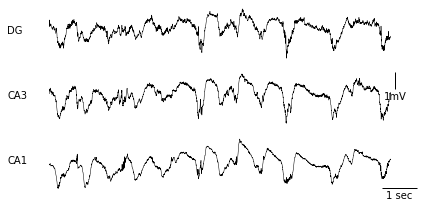

In [682]:
# LFP signals figure

lfp_figure = plt.figure(figsize=(6, 3))
ax_1 = plt.subplot(311)
plt.plot(traces['DG'][0:10000], '-k', linewidth = 0.5)
plt.annotate(s= 'DG', xy=(0, 0.5), xytext = (-25, 0), xycoords = 'axes fraction', textcoords = 'offset points')
plt.axis('off')

ax_2 = plt.subplot(312)
ax_2.plot(traces['CA3'][0:10000], '-k', linewidth = 0.5)
plt.annotate(s= 'CA3', xy=(0, 0.5), xytext = (-25, 0), xycoords = 'axes fraction', textcoords = 'offset points')
bar_v = AnchoredSizeBar(ax_2.transData, 10, '1mV', 1, frameon = False, pad = 0, size_vertical = 1000)
ax_2.add_artist(bar_v)
plt.axis('off')

ax_3 = plt.subplot(313)
plt.plot(traces['CA1'][0:10000], '-k', linewidth = 0.5)
plt.annotate(s= 'CA1', xy=(0, 0.5), xytext = (-25, 0), xycoords = 'axes fraction', textcoords = 'offset points')
plt.axis('off')
bar_h = AnchoredSizeBar(ax_3.transData, 1000, '1 sec', 4, frameon = False, borderpad = -1, size_vertical = 10)
ax_3.add_artist(bar_h)
plt.tight_layout()

In [683]:
psd = welch_spect(traces)

In [684]:
psd

,Frqs (Hz),DG_psd,DG_dB,CA3_psd,CA3_dB,CA1_psd,CA1_dB
0,0.5,80308.626789,-2.449761,65072.265277,-2.152181,42721.809979,-2.411226
1,1.0,141168.651086,0.000000,106810.524366,0.000000,74434.151240,0.000000
2,1.5,85703.821891,-2.167381,63571.208656,-2.253536,44106.311048,-2.272715
3,2.0,32899.388488,-6.325504,27879.105373,-5.833352,16499.169544,-6.543102
4,2.5,12522.328393,-10.520532,11584.272121,-9.647453,6978.896909,-10.279855
...,...,...,...,...,...,...,...
395,198.0,0.681925,-53.160019,0.387034,-54.408646,0.648622,-50.597808
396,198.5,0.679730,-53.174021,0.297071,-55.557539,0.712256,-50.191364
397,199.0,0.671559,-53.226539,0.291509,-55.639620,0.619533,-50.797078
398,199.5,0.807090,-52.428162,0.271159,-55.953906,0.396786,-52.732154


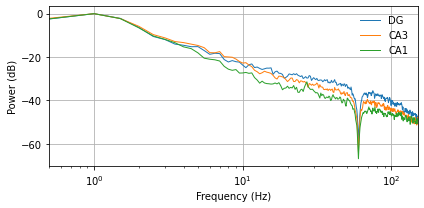

In [685]:
# Spectra figure

spect_fig = plt.figure(figsize= (6, 3))
ax_1= plt.subplot(111)
plt.plot(psd['Frqs (Hz)'], psd['DG_dB'], label = 'DG', linewidth = 1)
plt.plot(psd['Frqs (Hz)'], psd['CA3_dB'], label = 'CA3', linewidth = 1)
plt.plot(psd['Frqs (Hz)'], psd['CA1_dB'], label = 'CA1', linewidth = 1)
ax_1.set_xlim([0.5, 150])
#ax_1.set_xticks(np.linspace(0, 150, 16))
plt.grid(True)
plt.ylabel('Power (dB)')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
#plt.yscale('log')
plt.legend(frameon = False)

plt.tight_layout()

In [686]:
bands = tidy_psd(psd, bands_dic, power_dic, meta = META, columns = ['DG_psd', 'CA3_psd', 'CA1_psd'])

In [687]:
bands

,Date,Genotype,Sex,Tx,Site,total_pw,delta_abs,theta_abs,gamma_slow_abs,gamma_fast_abs,delta_rel,theta_rel,gamma_slow_rel,gamma_fast_rel
0,41021,WT,Male,Pl,DG,110310.59,52165.69,27825.78,2048.33,277.22,0.47,0.25,0.02,0.00
1,41021,WT,Male,Pl,CA3,15255.57,7412.66,2834.96,328.88,79.13,0.49,0.19,0.02,0.01
2,41021,WT,Male,Pl,CA1,18206.26,10884.41,3199.59,261.89,32.55,0.60,0.18,0.01,0.00
3,271021,WT,Fem,Tx1,DG,31273.89,9627.76,7707.18,1518.39,154.67,0.31,0.25,0.05,0.00
4,271021,WT,Fem,Tx1,CA3,26440.23,10275.11,8384.49,987.61,87.29,0.39,0.32,0.04,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,110821,KO,Fem,Tx05,CA3,94780.78,74611.41,12333.25,633.92,253.92,0.79,0.13,0.01,0.00
110,110821,KO,Fem,Tx05,CA1,76465.14,68197.82,4522.80,126.62,48.24,0.89,0.06,0.00,0.00
111,090821,KO,Fem,Pl,DG,188746.42,160085.13,13277.18,2012.19,660.99,0.85,0.07,0.01,0.00
112,090821,KO,Fem,Pl,CA3,146970.50,123759.58,12907.61,699.01,192.85,0.84,0.09,0.00,0.00


## Coherence

In [688]:
coh_df = welch_coh(coh_dic, traces, meta = META)
coh_df

,Date,Genotype,Sex,Tx,Site,Theta_Coh,SG_Coh,HG_Coh
0,41021,WT,Male,Pl,DG,0.204213,0.181128,0.117847
1,41021,WT,Male,Pl,CA3,1.000000,1.000000,1.000000
2,41021,WT,Male,Pl,CA1,0.176892,0.079037,0.054359
3,271021,WT,Fem,Tx1,DG,0.096834,0.151178,0.111472
4,271021,WT,Fem,Tx1,CA3,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
109,110821,KO,Fem,Tx05,CA3,1.000000,1.000000,1.000000
110,110821,KO,Fem,Tx05,CA1,0.225393,0.084150,0.057565
111,090821,KO,Fem,Pl,DG,0.481547,0.189715,0.311943
112,090821,KO,Fem,Pl,CA3,1.000000,1.000000,1.000000


Text(0.5, 0, 'Frequency (Hz)')

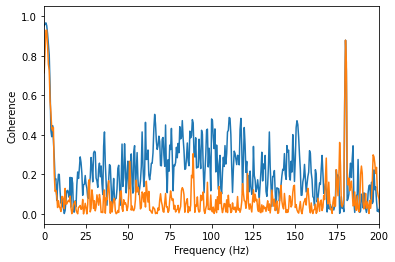

In [689]:
fqs_c, coh1, lags1 =spec.welch_coherence(traces['CA3'], traces['DG'], len_segment = 2000, overlap = 0, fs = 1000)
fqs_c, coh2, lags2 =spec.welch_coherence(traces['CA3'], traces['CA1'], len_segment = 2000, overlap = 0, fs = 1000)

coh_fig = plt.figure(figsize= (6, 4))
plt.plot(fqs_c, coh1)
plt.plot(fqs_c, coh2)
plt.xlim([0, 200])
plt.ylabel('Coherence')
plt.xlabel('Frequency (Hz)')

In [690]:
f'{Date}_{Genotype}_{Tx}_'

'090821_KO_Pl_'

In [691]:
lfp_figure.savefig(f'/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long/{Date}_{Genotype}_{Tx}_traces.svg')
spect_fig.savefig(f'/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long/{Date}_{Genotype}_{Tx}_psd.svg')
coh_fig.savefig(f'/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long/{Date}_{Genotype}_{Tx}_coh.svg')
psd.to_csv(f'/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long/{Date}_{Genotype}_{Tx}_psd.csv')

In [692]:
bands.to_csv('/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long/bands_pool.csv')

In [693]:
coh_df.to_csv('/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long/coh_pool.csv')